In [1]:
from ambiance import Atmosphere
import numpy as np

from global_variables.solver import EquationSystem
from global_variables.registry import VariableRegistry, Variable

registry = VariableRegistry("aero_vars.yaml")

In [2]:
system = EquationSystem(registry, targets={'R','W_f'})
R_solver = system.create_solver()
R_solver

{'R': <function _lambdifygenerated(C_D0, S_, TSFC, V, W_max, W_pax, We_Wmax, b, e, n_pax, rho_h)>,
 'W_f': <function _lambdifygenerated(C_D0, S_, TSFC, V, W_max, W_pax, We_Wmax, b, e, n_pax, rho_h)>}

In [3]:
# Fuel data dictionary
fuel_data = {
    'JP4': {'specific_energy': 43.15, 'density': 804, 'boiling_point': 176},
    'Butane': {'specific_energy': 49.5, 'density': 571.8, 'boiling_point': 0},
    'Propane': {'specific_energy': 50.3, 'density': 493, 'boiling_point': -42.25},
    'Methane': {'specific_energy': 55.5, 'density': 422.8, 'boiling_point': -161.49},
    'Hydrogen': {'specific_energy': 119, 'density': 70.85, 'boiling_point': -252.87}
}

JP_tsfc = 0.5
for fuel_type in fuel_data.keys():
    fuel_data[fuel_type]['tsfc'] = JP_tsfc * fuel_data['JP4']['specific_energy'] / fuel_data[fuel_type]['specific_energy']
fuel_data

{'JP4': {'specific_energy': 43.15,
  'density': 804,
  'boiling_point': 176,
  'tsfc': 0.5},
 'Butane': {'specific_energy': 49.5,
  'density': 571.8,
  'boiling_point': 0,
  'tsfc': 0.43585858585858583},
 'Propane': {'specific_energy': 50.3,
  'density': 493,
  'boiling_point': -42.25,
  'tsfc': 0.4289264413518887},
 'Methane': {'specific_energy': 55.5,
  'density': 422.8,
  'boiling_point': -161.49,
  'tsfc': 0.3887387387387387},
 'Hydrogen': {'specific_energy': 119,
  'density': 70.85,
  'boiling_point': -252.87,
  'tsfc': 0.18130252100840336}}

In [4]:
def velocity(M,h):
  atmo = Atmosphere(h * 0.3048)
  return atmo.speed_of_sound[-1] * M / 0.3048
def rho_func(h):
  atmo = Atmosphere(h * 0.3048)
  return atmo.density[-1] * 0.00194032

In [5]:
args = {
    "C_D0":0.02,
    "S_":9540.865,
    "TSFC":.45/3600,
    "V":velocity(M=.9,h=3.6e4),
    #"W_max":2e6,
    "W_pax":205,
    "We_Wmax":.46,
    "b":315,
    "e":0.9,
    "n_pax":1254,
    "rho_h":rho_func(3.6e4)
}

from scipy.optimize import minimize
def find_max_weight(desired_range,max_weight=2e6,**kwargs):
    return minimize(
        lambda w_max: (R_solver['R'](W_max=w_max,**kwargs) - desired_range)**2,
        x0=max_weight,
        #method="Nelder-Mead"
    )
out = find_max_weight(1e4*6076.12,max_weight=1.75e6,**args)
print(out['x'])

[1742056.27968414]


In [18]:
cTs = np.linspace(.15,.45,20)
W_maxs = []
W_fs = {}
args = {
        "C_D0":0.02,
        "S_":9540.865,
        "V":velocity(M=.9,h=3.6e4),
        #"W_max":2e6,
        "W_pax":205,
        "We_Wmax":.46,
        "b":315,
        "e":0.9,
        "n_pax":1254,
        "rho_h":rho_func(3.6e4)
    }

for cT in cTs:
    args["TSFC"] = cT/3600
    out = find_max_weight(1e4*6076.12,max_weight=1.75e6,**args)
    W_maxs.append(out['x'][0])
for fuel_type in fuel_data.keys():
    #print(fuel_type)
    args["TSFC"] = fuel_data[fuel_type]["tsfc"] / 3600
    #print(args)
    out = find_max_weight(1e4*6076.12,max_weight=1.75e6,**args)
    #print(out['x'][0])
    
    W_fs[fuel_type] = R_solver['W_f'](W_max=out['x'][0],**args)

In [52]:
densities = {key: val/fuel_data[key]['density']*119.8264300000003 for key,val in W_fs.items()}
print(densities)

{'JP4': 125390.16138634823, 'Butane': 135492.9163755458, 'Propane': 152948.8298747702, 'Methane': 152614.55938099348, 'Hydrogen': 352012.4964064876}


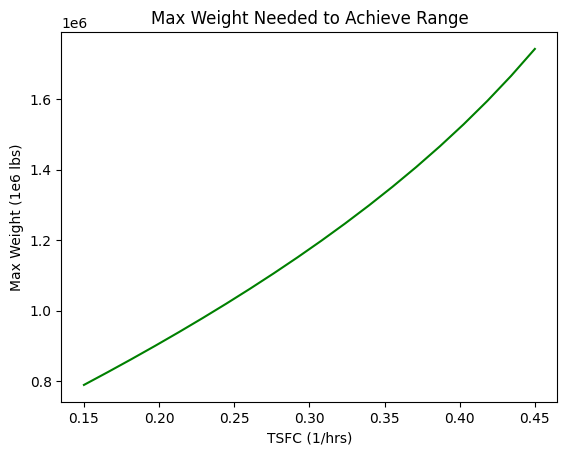

In [53]:
import matplotlib.pyplot as plt 

fig, ax1 = plt.subplots()

ax1.plot(cTs, W_maxs, 'g-')

ax1.set_xlabel("TSFC (1/hrs)")

ax1.set_ylabel('Max Weight (1e6 lbs)',)

plt.title("Max Weight Needed to Achieve Range")
plt.savefig("../assets/max_weight_vs_tsfc.png")



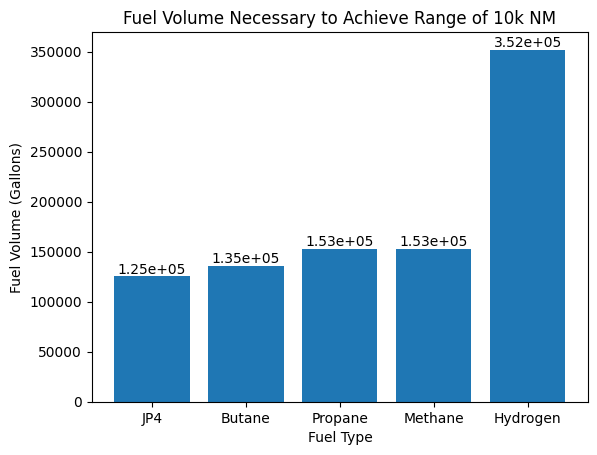

In [54]:
fuel_tsfcs = [fuel_data[fuel_type]['tsfc'] for fuel_type in W_fs.keys()]
fuel_volumes = list(densities.values())

bars = plt.bar(W_fs.keys(), fuel_volumes)
plt.xlabel("Fuel Type")
plt.ylabel('Fuel Volume (Gallons)')
plt.title("Fuel Volume Necessary to Achieve Range of 10k NM")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3g}',
             ha='center', va='bottom')
plt.savefig("../assets/necessary_fuel_volume.png")

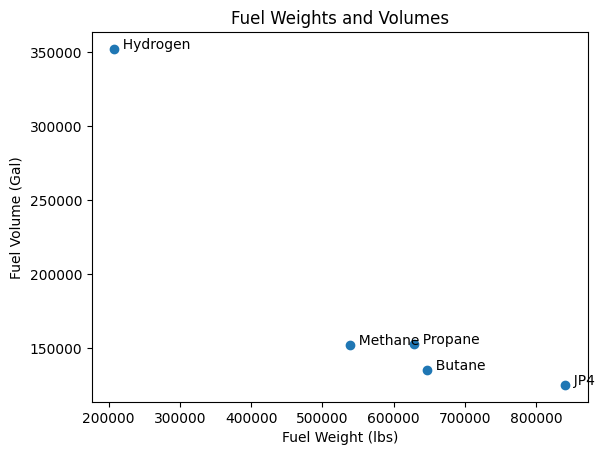

In [55]:
plt.scatter(W_fs.values(),fuel_volumes)
plt.xlabel("Fuel Weight (lbs)")
plt.ylabel("Fuel Volume (Gal)")
plt.title("Fuel Weights and Volumes")

for i,name in enumerate(W_fs.keys()):
    plt.annotate(f"  {name}",(W_fs[name],fuel_volumes[i]))

plt.savefig("../assets/fuel_weight_vs_volume.png")